In [25]:
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS, DiscreteHMCGibbs

import pandas as pd
import numpy as np
DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Cases.csv"

df = pd.read_csv(DATA_URI)

DATA_URI = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-truth/truth-Incident%20Deaths.csv"


df_deaths = pd.read_csv(DATA_URI)

fips_uri = "https://raw.githubusercontent.com/reichlab/covid19-forecast-hub/master/data-locations/locations.csv"

df_fips = pd.read_csv(fips_uri)

cases = df.set_index('location_name').join(df_fips.set_index('location_name'),how='left',lsuffix='test')
deaths = df_deaths.set_index('location_name').join(df_fips.set_index('location_name'),how='left',lsuffix='test')


region = "TX"
date = "2020-08-08"


cases=cases[cases.abbreviation==region]
deaths=deaths[deaths.abbreviation==region]


print (cases)


joined_df_full = cases.set_index('date').join(deaths.set_index('date'),how='left',lsuffix='cases',rsuffix='deaths')
joined_df = joined_df_full.loc[joined_df_full.index <= date]

joined_df_full.index = pd.to_datetime(joined_df_full.index)
joined_test = joined_df_full.loc[(joined_df_full.index >= pd.to_datetime(date) +pd.Timedelta("1 days")) & (joined_df_full.index <= pd.to_datetime(date) +pd.Timedelta("28 days"))]


joined_test_full = joined_df_full.loc[ (joined_df_full.index <= pd.to_datetime(date) +pd.Timedelta("28 days"))]




import jax
import rpy2
import numpy as np
from rpy2.robjects.packages import importr
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()
splines = importr("splines")
predict = importr("stats")


df_full = pd.DataFrame({'X':np.arange(len(joined_df.valuecases.tolist())),
                   'Y':np.array(joined_df.valuecases.tolist()),  # add your data here
                    'D': np.array(joined_df.valuedeaths.tolist())})
                  
df_train =df_full

knots=np.arange(0,len(df_full.X.values)-10,10)
knots = np.concatenate((knots,[len(df_full.X.values)+28]))

#knots= np.concatenate((knots[:-1],[len(df_full.X.values)+28]))
#print (knots)
basis = splines.bs(np.arange(0,len(df_full.X.values)+28),degree=3,knots=knots)


basis_matrix = np.array(basis)
basis_train= basis_matrix[:len(df_full.X.values),:]

#basis_oos = predict.predict(basis,newx=np.arange(1,(len(df_full.X.values)+29)))
basis_oos_matrix =basis_matrix
num_data =basis_matrix.shape[0]
num_basis = basis_matrix.shape[1]




def ExponentialRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
    
    Variables are x_0, ..., x_{T-1}
    
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc) 
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
        
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)        
    '''
    
    log_loc = np.log(loc) + drift * (np.arange(num_steps)+0.)
    
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = log_loc, scale=1.),
            dist.transforms.ExpTransform()
        ]
    )

def LogisticRandomWalk(loc=1., scale=1e-2, drift=0., num_steps=100):
    '''
    Return distrubtion of exponentiated Gaussian random walk
   
    Variables are x_0, ..., x_{T-1}
   
    Dynamics in log-space are random walk with drift:
       log(x_0) := log(loc)
       log(x_t) := log(x_{t-1}) + drift + eps_t,    eps_t ~ N(0, scale)
    
    ==> Dynamics in non-log space are:
        x_0 := loc
        x_t := x_{t-1} * exp(drift + eps_t),    eps_t ~ N(0, scale)
    '''
   
    logistic_loc = np.log(loc/(1-loc)) + drift * (np.arange(num_steps)+0.)
   
    return dist.TransformedDistribution(
        dist.GaussianRandomWalk(scale=scale, num_steps=num_steps),
        [
            dist.transforms.AffineTransform(loc = logistic_loc, scale=1.),
            dist.transforms.SigmoidTransform()
        ]
    )



mask = np.zeros((num_data,num_data))

for i in range(num_data):
    mask[i,:(i+31)] = 1
    
    



#case_normalizer = np.max(df_train.Y.values)
df_train.Y = np.log(df_train.Y.values+1)#/case_normalizer

#death_normalizer = np.max(df_train.D.values)
df_train.D = np.log(df_train.D.values+1)#/death_normalizer



mask_pred = np.zeros((num_data+28,num_data+28))

for i in range(num_data+28):
    mask_pred[i,:(i+1)] = 1


#offset= 7 
def model(obs_cases = None,obs_deaths= None,tmp_p = None, B_local=None,Forecast=False,num_data=None):

    #offset = numpyro.sample('offset',dist.Categorical(probs=jnp.repeat(1./20,20)))
    offset = dist.Categorical(jnp.repeat(1./20,20)).sample(rng_key)

    sigma = numpyro.sample('sigma',dist.Exponential(.1))
  
    sigma2 = numpyro.sample('sigma2',dist.Exponential(.1))
    
    p = numpyro.sample('translation', dist.Beta(1,1))
    tau = numpyro.sample('scale_on_coef',dist.Normal(0,1000))
    a_raw = numpyro.sample('a_raw',dist.GaussianRandomWalk(scale=1, num_steps=num_basis))
    b_raw = numpyro.sample('b_raw',dist.GaussianRandomWalk(scale=1, num_steps=num_basis))

    y_hat =  numpyro.deterministic('y_hat', jnp.dot(jnp.array(B_local), tau*a_raw))
    y_hat = p *y_hat
    numpyro.sample('y_obs', dist.Normal(y_hat,sigma), obs=obs_cases)
     
        
    lag_mask = jnp.arange(num_data) >= offset
    #if  not Forecast:
     #   y_hat_lagged = lag_mask*y_hat
    #else:
     #   y_hat_lagged = y_hat
    d_hat = numpyro.deterministic('d_hat',y_hat +jnp.dot(jnp.array(B_local), b_raw))

    if obs_deaths is not None:
        numpyro.sample('d_obs', dist.Normal(d_hat,sigma2).mask(lag_mask), obs=obs_deaths)
    else:
        numpyro.sample('d_obs', dist.Normal(d_hat,sigma2).mask(lag_mask), obs=obs_deaths)

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = DiscreteHMCGibbs(NUTS(model))
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_,obs_cases = df_train.Y.values,obs_deaths=df_train.D.values,B_local=basis_train,num_data=len(df_train.D.values))
mcmc.print_summary()
samples_1 = mcmc.get_samples()




from numpyro.infer import Predictive


predictive = Predictive(model, samples_1)
#predictions = predictive(rng_key_,
#                         Forecast=True,
 #                        B_local=basis_oos_matrix,
  #                       num_data=np.array(basis_oos_matrix).shape[0])['d_hat']

predictions_w_obs_noise = predictive(rng_key_,
                        Forecast=True,
                         B_local=basis_oos_matrix,
                         num_data=len(df_train.D.values)+28)['d_obs']


#case_predictions = predictive(rng_key_,
 #                        Forecast=True,
  #                       B_local=basis_oos_matrix,
   #                      num_data=np.array(basis_oos_matrix).shape[0])['y_hat']


case_predictions_w_obs_noise = predictive(rng_key_,
                        Forecast=True,
                    B_local=basis_oos_matrix,
                       num_data=len(df_train.D.values)+28)['y_obs']



#forecasts = (np.median(predictions,0)*death_normalizer)[-28:]
truth = joined_test.valuedeaths.values

#one_week_ahead_mae = np.abs( np.sum(forecasts[0:7])-np.sum(truth[0:7]))
#two_week_ahead_mae = np.abs( np.sum(forecasts[7:14])-np.sum(truth[7:14]))
#three_week_ahead_mae = np.abs( np.sum(forecasts[14:21])-np.sum(truth[14:21]))
#four_week_ahead_mae = np.abs( np.sum(forecasts[21:28])-np.sum(truth[21:28]))


#mae = np.array([one_week_ahead_mae,two_week_ahead_mae,three_week_ahead_mae,four_week_ahead_mae])



plt.style.use('ggplot')





/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


                     date locationtest  value abbreviation location  \
location_name                                                         
Texas          2020-01-24           48      0           TX       48   
Texas          2020-01-25           48      0           TX       48   
Texas          2020-01-26           48      0           TX       48   
Texas          2020-01-27           48      0           TX       48   
Texas          2020-01-28           48      0           TX       48   
...                   ...          ...    ...          ...      ...   
Texas          2021-01-19           48  19269           TX       48   
Texas          2021-01-20           48  28095           TX       48   
Texas          2021-01-21           48  23317           TX       48   
Texas          2021-01-22           48  18918           TX       48   
Texas          2021-01-23           48  14684           TX       48   

               population  
location_name              
Texas          28995

  0%|          | 0/3000 [00:00<?, ?it/s]/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/jax/_src/random.py:527: RuntimeWarning: divide by zero encountered in log
  num_rounds = int(np.ceil(exponent * np.log(x.size) / np.log(uint32max)))
  0%|          | 0/3000 [00:00<?, ?it/s]


OverflowError: cannot convert float infinity to integer

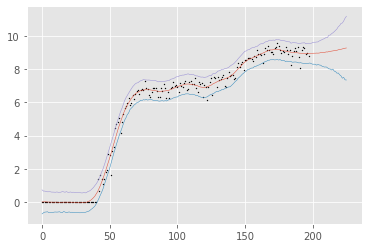

In [24]:
plt.style.use('ggplot')

fig1, ax1 = plt.subplots()

ax1.plot(case_predictions_w_obs_noise.mean(axis=0),linewidth=.5)
ax1.plot(np.quantile(case_predictions_w_obs_noise,axis=0,q=.025),linewidth=.5)
ax1.plot(np.quantile(case_predictions_w_obs_noise,axis=0,q=.975),linewidth=.5)

ax1.scatter(df_train.X.values,df_train.Y.values,color='black',s=.75)
#ax1.plot(np.median(predictions,axis=0))


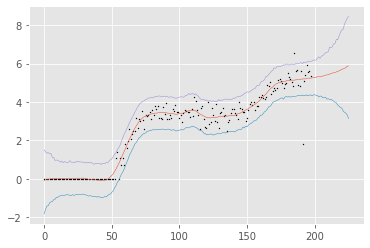

In [22]:
plt.style.use('ggplot')

fig1, ax1 = plt.subplots()

ax1.plot(predictions_w_obs_noise.mean(axis=0),linewidth=.5)
ax1.plot(np.quantile(predictions_w_obs_noise,axis=0,q=.025),linewidth=.5)
ax1.plot(np.quantile(predictions_w_obs_noise,axis=0,q=.975),linewidth=.5)

ax1.scatter(df_train.X.values,df_train.D.values,color='black',s=.75)
#ax1.plot(np.median(predictions,axis=0))
